In [1]:
# this code doesn't work yet... 
# I've been working on constructing FIM for this project more recently, and have kind of abandoned the sparse GP precomputation approach
import os
import sys


sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

import torchsde
from fractional_neural_sde.controlled_fractional_noise import SparseGPNoise
from fractional_neural_sde.latent_sde import LatentSDE
from fractional_neural_sde.utils import LinearScheduler, manual_seed, plot_setting
from torch import distributions, optim

plot_setting(font_size=20)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) #plots do not work without this



In [2]:
class TrueNoise(SparseGPNoise):
    def compute_hurst(self, t):
        t = t.view(-1, 1)
        return torch.ones(1, 1) * torch.sigmoid((1.0 - t) * 7.0) * 0.5 + 0.3


def get_data():

    t0, t1 = 0.0, 2.0
    batch_size = 200

    x0 = 1.0
    alpha = 0.5
    beta = 0.5
    true_wn = TrueNoise(t0=t0, t1=t1, dt=1e-2, num_steps=500, num_inducings=50)

    true_wn.precompute(batch_size=batch_size)

    ts, B_h, _ = true_wn.sample_alternative(batch_size)

    ht = torch.stack(
        [true_wn.compute_hurst(t) for t in ts], dim=0
    )  # t_size, 1, state_size

    # the exact solution
    X_t = x0 * torch.exp(
        beta * B_h
        + alpha * ts.reshape(-1, 1, 1)
        - 0.5 * beta**2 * ts.reshape(-1, 1, 1) ** (2 * ht)
    )
    X_t = X_t.squeeze().transpose(0, 1)

    # shift time a bit
    shift = 0.1
    start = ts[0].reshape((1,))
    end = ts[-1].reshape((1,)) + shift
    ts = ts + shift
    ts_ext = torch.cat([start, ts, end], dim=0)

    return ts, ts_ext, X_t[1], ht

In [3]:
def plot(
    sample_fn, ts, ys, ts_vis, batch_size, sdeint_fn, eps, bm, method, dt, prior=True
):

    palette = sns.color_palette("Blues_r")

    fill_color = palette[2]
    mean_color = palette[0]

    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

    with torch.no_grad():
        zs = sample_fn(
            ts=ts_vis,
            batch_size=batch_size,
            sdeint_fn=sdeint_fn,
            method=method,
            dt=dt,
            bm=bm,
            eps=eps,
        )
        zs = zs.squeeze()
        ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
        zs_ = np.sort(zs_, axis=1)

        plt.subplots(figsize=(8, 4), frameon=False)

        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2.0 * batch_size)
            zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
            plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

        if not prior:
            # plot mean
            plt.plot(
                ts_vis_,
                zs_.mean(axis=1),
                color=mean_color,
                linestyle="--",
                linewidth=2.5,
            )

        # plot data
        if ys.ndim == 2:
            plt.scatter(ts, ys[:, 0], marker="x", zorder=3, color="k", s=50)
        else:
            plt.scatter(ts, ys, marker="x", zorder=3, color="k", s=50)

        plt.xlabel("$t$")
        plt.ylabel("$X_t$")
        plt.tight_layout()


def plot_posterior(
    sample_fn, ts, ys, ts_vis, batch_size, sdeint_fn, eps, bm, method, dt
):
    plot(
        sample_fn,
        ts,
        ys,
        ts_vis,
        batch_size,
        sdeint_fn,
        eps,
        bm,
        method,
        dt,
        prior=False,
    )


def plot_h(hurst_fn, ts_vis, ts, true_ht, shift=0.05):
    """Plot Hurst function"""
    plt.figure(figsize=(5, 4))

    with torch.no_grad():
        ht = hurst_fn(ts_vis)
        ts_vis_, ht_ = ts_vis.cpu().numpy(), ht.cpu().numpy()

        plt.plot(ts_vis_ - shift, ht_, label="ours", alpha=0.8)
        plt.plot(ts - shift, true_ht, label="true", alpha=0.8)
        plt.xlabel(r"$t$")
        plt.ylabel(r"$h(t)$")
        plt.legend()
def plot_loss(loss, iterations):
    """Plot loss"""
    plt.figure(figsize=(5, 4))
    plt.plot(iterations, loss, label="ours", alpha=0.8)
    plt.xlabel(r"$iteration$")
    plt.ylabel(r"$loss$")
    plt.legend()

In [4]:
train_dir = "./dump/"
adjoint = False
device = "cuda"
train_iters = 3000
kl_anneal_iters = 100
likelihood_cls = distributions.Laplace
scale = 0.025
method = "euler"
dt = 5 * 1e-3
batch_size = 1
seed = 0

In [5]:
manual_seed(seed)

device = torch.device(device if torch.cuda.is_available() else "cpu")
train_dir = os.path.join(train_dir, "synthetic")
ckpt_dir = os.path.join(train_dir, "ckpts")
os.makedirs(ckpt_dir, exist_ok=True)
ts, ts_ext, ys, ht = get_data()

ts_, ys_ = ts, ys
ht = ht.squeeze()

ts, ys = ts.to(device), ys.to(device)[:, None]

In [6]:
# plt.figure()
# plt.scatter(ts_, ys_, s=50)
white_noise = SparseGPNoise(
    t0=ts_ext[0], t1=ts_ext[-1], dt=dt, num_steps=200, num_inducings=100
).to(device)

model = LatentSDE(white_noise).to(device)
sdeint_fn = torchsde.sdeint_adjoint if adjoint else torchsde.sdeint
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
kl_scheduler = LinearScheduler(iters=kl_anneal_iters)

In [7]:
# weights = [param for param in model.net.parameters()]
# weights

In [8]:
optimizer.zero_grad()
zs, kl = model(
        ts=ts, batch_size=batch_size, sdeint_fn=sdeint_fn, method=method, dt=dt
    )
zs = zs.squeeze()
zs = zs[1:-1]

likelihood = likelihood_cls(loc=zs, scale=scale)
logpy = likelihood.log_prob(ys[1:-1]).sum(dim=0).mean(dim=0)

loss = -logpy + kl * kl_scheduler.val
#loss_graph.append(loss.cpu().detach().cpu().numpy())
#iter_graph.append(i)
loss.backward()
optimizer.step()
scheduler.step()
kl_scheduler.step()

In [9]:
A = model.noise_path.path_mask
B = model.noise_path.Z
torch.where((B == A.unsqueeze(1)).all(-1).any(-1))
#torch.cat([model.noise_path.Z, torch.tensor(model.noise_path.Z[99] +1)], dim = -1)
model.CDE_path[1:model.CDE_path.shape[0]].shape
#model.noise_path.coeffs_yt.shape

torch.Size([100, 2])

In [ ]:
[model.net(torch.tensor([1.,1.,1.])), torch.tensor(model.qy0_mean.data).reshape(1)]

In [ ]:
white_noise = SparseGPNoise(
    t0=ts_ext[0], t1=ts_ext[-1], dt=dt, num_steps=200, num_inducings=50
).to(device)

model = LatentSDE(white_noise).to(device)
sdeint_fn = torchsde.sdeint_adjoint if adjoint else torchsde.sdeint
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
kl_scheduler = LinearScheduler(iters=kl_anneal_iters)

# for visualization
vis_batch_size = 1024
ts_vis = torch.linspace(ts_ext[0], ts_ext[-1], 300).to(device)
eps = torch.randn(vis_batch_size, 1).to(device)
bm_vis = torchsde.BrownianInterval(
    t0=ts_ext[0],
    t1=ts_ext[-1],
    size=(vis_batch_size, 1),
    device=device,
    levy_area_approximation="space-time",
)

loss_graph = []
iter_graph = []
for i in range(train_iters):
    #if i % 300 == 0:
    #    plot_posterior(
    #        model.sample_q,
    #        ts=ts_,
    #        ys=ys_,
    #        ts_vis=ts_vis,
    #        batch_size=vis_batch_size,
    #        sdeint_fn=sdeint_fn,
    #        bm=bm_vis,
    #        eps=eps,
    #        method=method,
    #        dt=dt,
    #    )
    #    plot_h(model.noise_path.compute_hurst, ts, ts_, ht)
    #    plt.show()
    #    plt.close()

    optimizer.zero_grad()
    zs, kl = model(
        ts=ts, batch_size=batch_size, sdeint_fn=sdeint_fn, method=method, dt=dt
    )
    zs = zs.squeeze()
    zs = zs[1:-1]

    likelihood = likelihood_cls(loc=zs, scale=scale)
    logpy = likelihood.log_prob(ys[1:-1]).sum(dim=0).mean(dim=0)

    loss = -logpy + kl * kl_scheduler.val
    loss_graph.append(loss.cpu().detach().cpu().numpy())
    iter_graph.append(i)
    loss.backward()
    
    
    optimizer.step()
    scheduler.step()
    kl_scheduler.step()
    if i % 500 == 0:
        print(
            f"Iter: {i} \t"
            f"logpy: {logpy.detach().cpu().numpy():.3f} \t"
            f"kl: {kl.cpu().detach().cpu().numpy():.3f} \t"
            f"loss: {loss.cpu().detach().cpu().numpy():.3f}"
        )
        plot_loss(loss_graph[i-500:i-1], iter_graph[i-500:i-1])
        mpl.pyplot.show()

In [12]:
weights = [param for param in model.net.parameters()]
weights

[Parameter containing:
 tensor([[ 0.2880, -0.4002, -0.0431],
         [    nan,     nan,     nan],
         [ 0.5422, -0.4574, -0.2449],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [ 0.1702, -0.5393, -0.4933],
         [-0.2764, -0.0426, -0.3146],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [-0.1275,  0.0191, -0.2890]], requires_grad=True),
 Parameter containing:
 tensor([-0.3285,     nan, -0.2022,     nan,     nan,  0.3514,  0.2746,     nan,
             nan,  0.0278], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0664, -0.1057, -0.0222,  0.0628, -0.0444,  0.0626,  0.0118, -0.0165,
           0.0327,  0.0421],
         [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan],
         [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan],
         [ 0.0200, -0.0191,  0.0591,  0.0610,  0.0502,  0.0482, -0

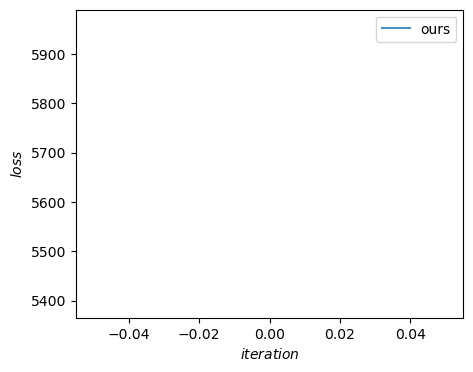

In [11]:
plot_loss(loss_graph, iter_graph)
#plot_loss(loss_graph[i-100:i-1], iter_graph[i-100:i-1])
mpl.pyplot.show()

In [17]:
loss_graph[len(loss_graph)-4]

array(943.711, dtype=float32)

In [14]:
def plot_h(hurst_fn, ts, y0, shift=0.0):
    """Plot Hurst function"""
    plt.figure(figsize=(5, 4))
    ht = []

    with torch.no_grad():
        for t, y in zip(ts, ys):
            ht.append(hurst_fn(t, y))
        ht = torch.tensor(ht)
        plt.plot(ts, ht, label=r"$h(t, X)$", alpha=0.8)
        plt.xlabel(r"$t$")
        plt.ylabel(r"$Hurst$")
        plt.legend()
def plot_true_h(ts, ht, shift=0.0):
    """Plot Hurst function"""
    """Plot Hurst function"""
    plt.figure(figsize=(5, 4))

    with torch.no_grad():

        plt.plot(ts - shift, ht, label="true h", alpha=0.8)
        plt.xlabel(r"$t$")
        plt.ylabel(r"$Hurst$")
        plt.legend()


In [ ]:
plot_h(model.noise_path.compute_hurst, ts, ys)
mpl.pyplot.show()

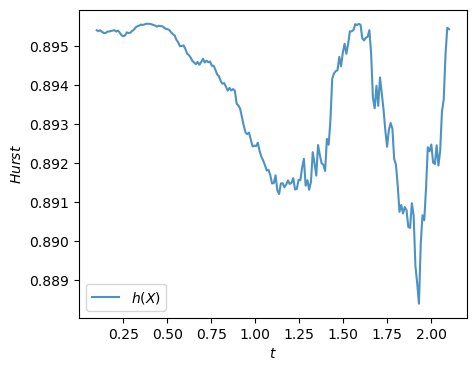

In [10]:
plot_control(model, ts, ys)
mpl.pyplot.show()

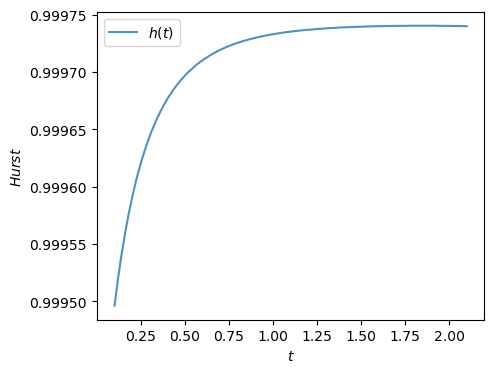

In [11]:
plot_condition(model, ts, ys)
mpl.pyplot.show()

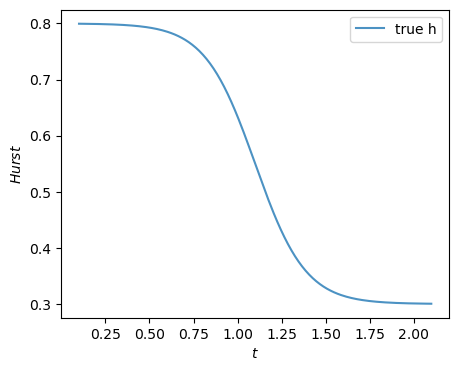

In [12]:
plot_true_h(ts, ht)
mpl.pyplot.show()

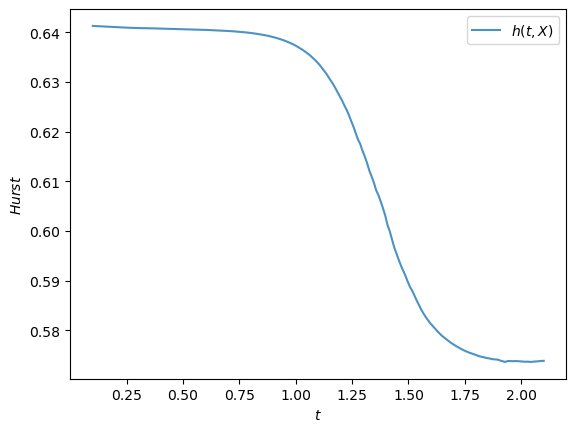

In [12]:
test = []
with torch.no_grad():
    count = 0
    for y in ys:
        t = ts[count]
        test.append(model.noise_path.driving_action(torch.tensor([torch.sin(t), torch.cos(t), t, y])))
        count = count + 1
    test = torch.tensor(test)
    plt.plot(ts, test, label=r"$h(t, X)$", alpha=0.8)
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Hurst$")
    plt.legend()
    mpl.pyplot.show


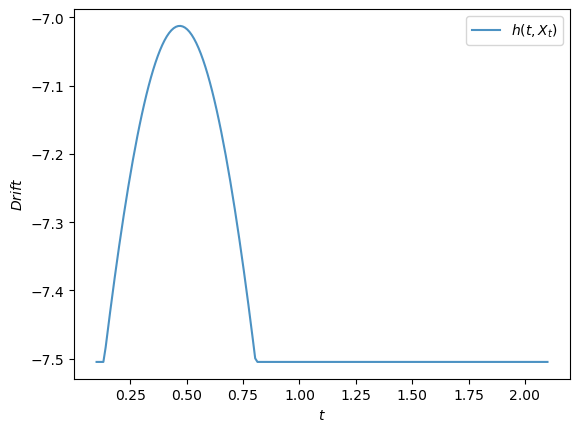

In [11]:
# for visualization of drift
drift = []
with torch.no_grad():
    count = 0
    for t in ts:
        drift.append(model.net(torch.tensor([torch.sin(t), torch.cos(t), ys[0]])))
        count = count + 1
    drift = torch.tensor(drift)
    plt.plot(ts, drift, label=r"$h(t, X_t)$", alpha=0.8)
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Drift$")
    plt.legend()
    mpl.pyplot.show

In [ ]:
def plot_control(model, ts, y0, shift=0.0):
    """Plot Hurst function"""
    plt.figure(figsize=(5, 4))
    ht = []

    with torch.no_grad():
        for y in ys:
            ht.append(model.noise_path.condition_net(y))
        ht = torch.tensor(ht)
        plt.plot(ts, ht, label=r"$h(X)$", alpha=0.8)
        plt.xlabel(r"$t$")
        plt.ylabel(r"$Hurst$")
        plt.legend()
def plot_condition(model, ts, y0, shift=0.0):
    """Plot Hurst function"""
    plt.figure(figsize=(5, 4))
    ht = []

    with torch.no_grad():
        for t in ts:
            ht.append(model.noise_path.driving_action(torch.tensor([torch.sin(t), torch.cos(t), t])))
        ht = torch.tensor(ht)
        plt.plot(ts, ht, label=r"$h(t)$", alpha=0.8)
        plt.xlabel(r"$t$")
        plt.ylabel(r"$Hurst$")
        plt.legend()